# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [109]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

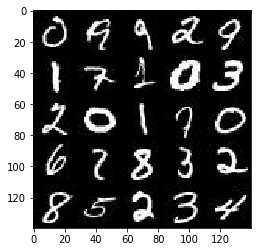

In [110]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

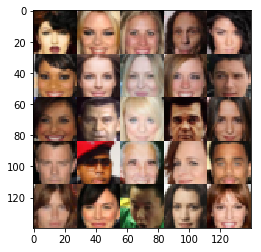

In [111]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [112]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [113]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    inputs_real = tf.placeholder(tf.float32, shape=[None, image_width, image_height, image_channels], name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    
    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [163]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope('discriminator', reuse=reuse):
        alpha = 0.2
        # Input layer is 28x28x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        #print(relu1.shape)
        # 14x14x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x256
        
        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [164]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope('generator', reuse=not is_train):
        alpha = 0.2
        # First fully connected layer
        x1 = tf.layers.dense(z, 4*4*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 4, 4, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 4x4x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 4, strides=1, padding='valid')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 7x7x256 now
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 14x14x128 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 4, strides=2, padding='same')
        # 28x28xout_channel_dim now    
        
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [165]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [166]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [167]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [168]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    input_real, input_z, learning_rate = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    steps = 0
    sample_z = np.random.uniform(-1, 1, size=(72, z_dim))

    samples, losses = [], []
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps+=1
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                batch_images *= 2
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, learning_rate: 0.0002})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images, learning_rate: 0.0002})

                if steps % 10 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % 100 == 0:
                    _ = show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)



### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.1901... Generator Loss: 4.0070
Epoch 1/2... Discriminator Loss: 0.2710... Generator Loss: 1.7027
Epoch 1/2... Discriminator Loss: 0.0598... Generator Loss: 3.6634
Epoch 1/2... Discriminator Loss: 0.4010... Generator Loss: 7.5427
Epoch 1/2... Discriminator Loss: 0.4348... Generator Loss: 8.1788
Epoch 1/2... Discriminator Loss: 0.3470... Generator Loss: 6.5689
Epoch 1/2... Discriminator Loss: 0.1873... Generator Loss: 3.6600
Epoch 1/2... Discriminator Loss: 0.3325... Generator Loss: 3.7646
Epoch 1/2... Discriminator Loss: 1.8988... Generator Loss: 0.2802
Epoch 1/2... Discriminator Loss: 0.9840... Generator Loss: 1.0278


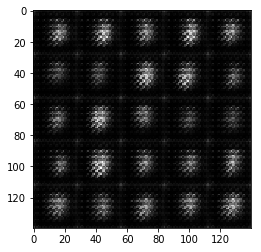

Epoch 1/2... Discriminator Loss: 0.1865... Generator Loss: 2.5290
Epoch 1/2... Discriminator Loss: 0.4231... Generator Loss: 1.7711
Epoch 1/2... Discriminator Loss: 0.3329... Generator Loss: 2.2651
Epoch 1/2... Discriminator Loss: 0.5311... Generator Loss: 1.6675
Epoch 1/2... Discriminator Loss: 0.4229... Generator Loss: 2.1367
Epoch 1/2... Discriminator Loss: 0.5398... Generator Loss: 1.5780
Epoch 1/2... Discriminator Loss: 0.5185... Generator Loss: 1.9774
Epoch 1/2... Discriminator Loss: 0.5899... Generator Loss: 1.2326
Epoch 1/2... Discriminator Loss: 0.7740... Generator Loss: 3.4451
Epoch 1/2... Discriminator Loss: 0.5741... Generator Loss: 2.0084


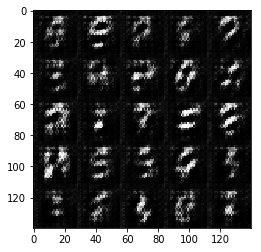

Epoch 1/2... Discriminator Loss: 1.6802... Generator Loss: 5.0000
Epoch 1/2... Discriminator Loss: 0.7365... Generator Loss: 1.4104
Epoch 1/2... Discriminator Loss: 0.7486... Generator Loss: 1.5184
Epoch 1/2... Discriminator Loss: 1.0484... Generator Loss: 1.9355
Epoch 1/2... Discriminator Loss: 1.0062... Generator Loss: 0.9927
Epoch 1/2... Discriminator Loss: 0.8054... Generator Loss: 2.0760
Epoch 1/2... Discriminator Loss: 0.6928... Generator Loss: 1.2854
Epoch 1/2... Discriminator Loss: 1.2328... Generator Loss: 0.5230
Epoch 1/2... Discriminator Loss: 0.7215... Generator Loss: 1.4357
Epoch 1/2... Discriminator Loss: 0.8790... Generator Loss: 1.6876


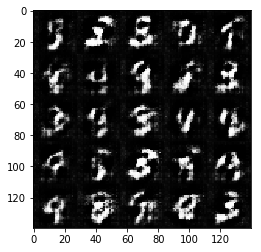

Epoch 1/2... Discriminator Loss: 0.7399... Generator Loss: 1.2571
Epoch 1/2... Discriminator Loss: 1.1295... Generator Loss: 0.5943
Epoch 1/2... Discriminator Loss: 0.7786... Generator Loss: 1.0037
Epoch 1/2... Discriminator Loss: 1.0484... Generator Loss: 0.6594
Epoch 1/2... Discriminator Loss: 0.9005... Generator Loss: 1.1703
Epoch 1/2... Discriminator Loss: 0.9762... Generator Loss: 1.1158
Epoch 1/2... Discriminator Loss: 0.8583... Generator Loss: 1.4779
Epoch 1/2... Discriminator Loss: 0.9675... Generator Loss: 0.8021
Epoch 1/2... Discriminator Loss: 0.7937... Generator Loss: 1.5364
Epoch 1/2... Discriminator Loss: 0.8550... Generator Loss: 1.2739


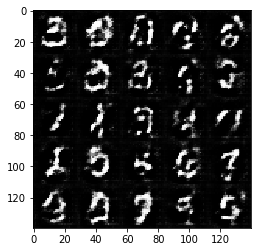

Epoch 1/2... Discriminator Loss: 0.8271... Generator Loss: 1.0321
Epoch 1/2... Discriminator Loss: 0.6862... Generator Loss: 1.2859
Epoch 1/2... Discriminator Loss: 0.6993... Generator Loss: 2.1080
Epoch 1/2... Discriminator Loss: 1.2168... Generator Loss: 2.5464
Epoch 1/2... Discriminator Loss: 0.6864... Generator Loss: 1.4442
Epoch 1/2... Discriminator Loss: 0.9458... Generator Loss: 2.1439
Epoch 2/2... Discriminator Loss: 0.7184... Generator Loss: 1.2222
Epoch 2/2... Discriminator Loss: 0.9635... Generator Loss: 2.7209
Epoch 2/2... Discriminator Loss: 0.7033... Generator Loss: 1.9681
Epoch 2/2... Discriminator Loss: 0.7247... Generator Loss: 1.2725


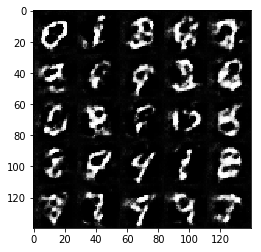

Epoch 2/2... Discriminator Loss: 0.6471... Generator Loss: 1.4738
Epoch 2/2... Discriminator Loss: 0.9425... Generator Loss: 0.6866
Epoch 2/2... Discriminator Loss: 0.7059... Generator Loss: 0.9837
Epoch 2/2... Discriminator Loss: 0.6982... Generator Loss: 1.5141
Epoch 2/2... Discriminator Loss: 0.8769... Generator Loss: 0.8266
Epoch 2/2... Discriminator Loss: 0.7961... Generator Loss: 1.0015
Epoch 2/2... Discriminator Loss: 1.5533... Generator Loss: 0.3299
Epoch 2/2... Discriminator Loss: 0.7959... Generator Loss: 0.8765
Epoch 2/2... Discriminator Loss: 0.7257... Generator Loss: 1.3803
Epoch 2/2... Discriminator Loss: 0.7825... Generator Loss: 1.0158


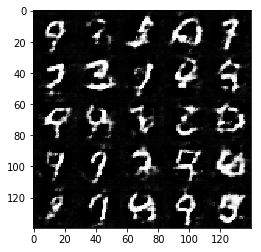

Epoch 2/2... Discriminator Loss: 1.0451... Generator Loss: 0.5834
Epoch 2/2... Discriminator Loss: 0.7815... Generator Loss: 0.9511
Epoch 2/2... Discriminator Loss: 1.0379... Generator Loss: 0.6493
Epoch 2/2... Discriminator Loss: 0.7443... Generator Loss: 1.1270
Epoch 2/2... Discriminator Loss: 0.7713... Generator Loss: 1.3457
Epoch 2/2... Discriminator Loss: 0.8592... Generator Loss: 1.2006
Epoch 2/2... Discriminator Loss: 0.8264... Generator Loss: 0.8931
Epoch 2/2... Discriminator Loss: 0.7882... Generator Loss: 1.0077
Epoch 2/2... Discriminator Loss: 0.9395... Generator Loss: 1.9943
Epoch 2/2... Discriminator Loss: 0.7750... Generator Loss: 1.5802


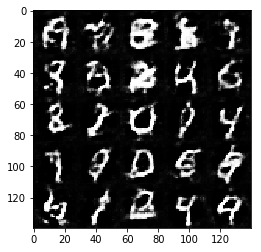

Epoch 2/2... Discriminator Loss: 1.1200... Generator Loss: 0.5398
Epoch 2/2... Discriminator Loss: 0.7849... Generator Loss: 1.4525
Epoch 2/2... Discriminator Loss: 0.6656... Generator Loss: 1.6179
Epoch 2/2... Discriminator Loss: 0.7236... Generator Loss: 1.4700
Epoch 2/2... Discriminator Loss: 0.7678... Generator Loss: 0.9649
Epoch 2/2... Discriminator Loss: 0.9591... Generator Loss: 0.7236
Epoch 2/2... Discriminator Loss: 0.9387... Generator Loss: 0.7175
Epoch 2/2... Discriminator Loss: 0.8089... Generator Loss: 1.4222
Epoch 2/2... Discriminator Loss: 0.7178... Generator Loss: 1.6553
Epoch 2/2... Discriminator Loss: 1.1553... Generator Loss: 2.2912


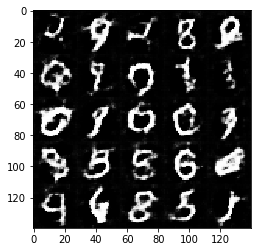

Epoch 2/2... Discriminator Loss: 0.6989... Generator Loss: 1.2668
Epoch 2/2... Discriminator Loss: 0.7465... Generator Loss: 1.1201
Epoch 2/2... Discriminator Loss: 0.8476... Generator Loss: 0.8107
Epoch 2/2... Discriminator Loss: 0.7507... Generator Loss: 2.1244
Epoch 2/2... Discriminator Loss: 0.8381... Generator Loss: 0.7623
Epoch 2/2... Discriminator Loss: 0.7363... Generator Loss: 0.9991
Epoch 2/2... Discriminator Loss: 0.6965... Generator Loss: 1.5540
Epoch 2/2... Discriminator Loss: 0.7279... Generator Loss: 1.0235
Epoch 2/2... Discriminator Loss: 1.0080... Generator Loss: 0.6049
Epoch 2/2... Discriminator Loss: 0.8441... Generator Loss: 1.3279


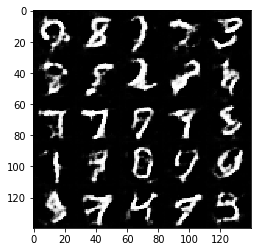

Epoch 2/2... Discriminator Loss: 0.7951... Generator Loss: 0.8931
Epoch 2/2... Discriminator Loss: 0.6694... Generator Loss: 1.2783
Epoch 2/2... Discriminator Loss: 0.6769... Generator Loss: 1.3660


In [169]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.7238... Generator Loss: 1.2686
Epoch 1/1... Discriminator Loss: 0.6376... Generator Loss: 1.1022
Epoch 1/1... Discriminator Loss: 0.1651... Generator Loss: 3.7710
Epoch 1/1... Discriminator Loss: 0.2174... Generator Loss: 6.6113
Epoch 1/1... Discriminator Loss: 0.2468... Generator Loss: 2.1841
Epoch 1/1... Discriminator Loss: 0.1303... Generator Loss: 9.5978
Epoch 1/1... Discriminator Loss: 0.2581... Generator Loss: 2.1358
Epoch 1/1... Discriminator Loss: 3.0018... Generator Loss: 0.0651
Epoch 1/1... Discriminator Loss: 1.0692... Generator Loss: 0.6115
Epoch 1/1... Discriminator Loss: 0.6760... Generator Loss: 1.1312


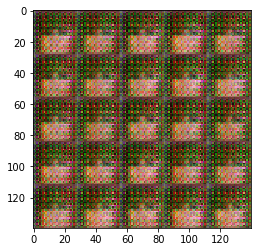

Epoch 1/1... Discriminator Loss: 0.4450... Generator Loss: 1.9146
Epoch 1/1... Discriminator Loss: 0.3473... Generator Loss: 2.4259
Epoch 1/1... Discriminator Loss: 0.7169... Generator Loss: 0.9995
Epoch 1/1... Discriminator Loss: 0.2398... Generator Loss: 2.9060
Epoch 1/1... Discriminator Loss: 0.4930... Generator Loss: 1.9246
Epoch 1/1... Discriminator Loss: 0.6386... Generator Loss: 1.6556
Epoch 1/1... Discriminator Loss: 0.7112... Generator Loss: 1.0233
Epoch 1/1... Discriminator Loss: 0.4743... Generator Loss: 3.8854
Epoch 1/1... Discriminator Loss: 0.5070... Generator Loss: 1.3624
Epoch 1/1... Discriminator Loss: 0.4093... Generator Loss: 2.1771


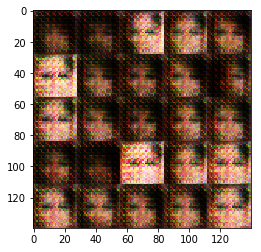

Epoch 1/1... Discriminator Loss: 0.5222... Generator Loss: 1.3307
Epoch 1/1... Discriminator Loss: 0.3613... Generator Loss: 2.3021
Epoch 1/1... Discriminator Loss: 0.7805... Generator Loss: 2.6441
Epoch 1/1... Discriminator Loss: 0.4681... Generator Loss: 1.6291
Epoch 1/1... Discriminator Loss: 0.4732... Generator Loss: 3.1349
Epoch 1/1... Discriminator Loss: 0.4337... Generator Loss: 1.9113
Epoch 1/1... Discriminator Loss: 0.6817... Generator Loss: 1.1685
Epoch 1/1... Discriminator Loss: 0.6199... Generator Loss: 1.2615
Epoch 1/1... Discriminator Loss: 1.2964... Generator Loss: 2.7988
Epoch 1/1... Discriminator Loss: 0.9011... Generator Loss: 1.6104


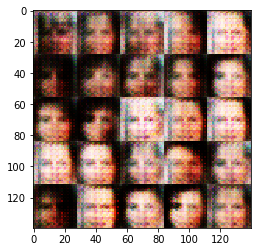

Epoch 1/1... Discriminator Loss: 0.8699... Generator Loss: 2.0456
Epoch 1/1... Discriminator Loss: 0.9462... Generator Loss: 0.8238
Epoch 1/1... Discriminator Loss: 0.7327... Generator Loss: 1.1121
Epoch 1/1... Discriminator Loss: 0.5256... Generator Loss: 2.5017
Epoch 1/1... Discriminator Loss: 0.6266... Generator Loss: 1.7243
Epoch 1/1... Discriminator Loss: 1.3717... Generator Loss: 2.7907
Epoch 1/1... Discriminator Loss: 0.7480... Generator Loss: 1.4440
Epoch 1/1... Discriminator Loss: 0.7984... Generator Loss: 1.6507
Epoch 1/1... Discriminator Loss: 0.8586... Generator Loss: 1.6754
Epoch 1/1... Discriminator Loss: 0.8338... Generator Loss: 1.5680


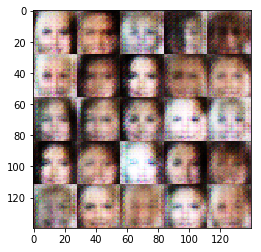

Epoch 1/1... Discriminator Loss: 1.3904... Generator Loss: 1.6979
Epoch 1/1... Discriminator Loss: 0.8946... Generator Loss: 0.8490
Epoch 1/1... Discriminator Loss: 1.5759... Generator Loss: 0.4042
Epoch 1/1... Discriminator Loss: 1.3079... Generator Loss: 2.1093
Epoch 1/1... Discriminator Loss: 0.9016... Generator Loss: 1.3804
Epoch 1/1... Discriminator Loss: 0.8127... Generator Loss: 1.3786
Epoch 1/1... Discriminator Loss: 0.8937... Generator Loss: 1.1941
Epoch 1/1... Discriminator Loss: 0.9809... Generator Loss: 1.0317
Epoch 1/1... Discriminator Loss: 0.9375... Generator Loss: 0.8356
Epoch 1/1... Discriminator Loss: 1.0061... Generator Loss: 1.1573


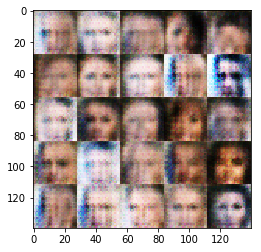

Epoch 1/1... Discriminator Loss: 1.1864... Generator Loss: 0.8295
Epoch 1/1... Discriminator Loss: 1.2471... Generator Loss: 1.6437
Epoch 1/1... Discriminator Loss: 1.0129... Generator Loss: 2.3133
Epoch 1/1... Discriminator Loss: 1.1139... Generator Loss: 0.7050
Epoch 1/1... Discriminator Loss: 0.8938... Generator Loss: 1.4741
Epoch 1/1... Discriminator Loss: 1.0777... Generator Loss: 0.8871
Epoch 1/1... Discriminator Loss: 1.1259... Generator Loss: 0.8584
Epoch 1/1... Discriminator Loss: 1.3540... Generator Loss: 1.9154
Epoch 1/1... Discriminator Loss: 1.1567... Generator Loss: 0.7219
Epoch 1/1... Discriminator Loss: 1.3063... Generator Loss: 1.2960


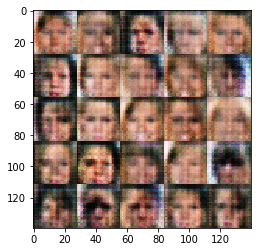

Epoch 1/1... Discriminator Loss: 1.5135... Generator Loss: 0.6647
Epoch 1/1... Discriminator Loss: 1.1629... Generator Loss: 0.8486
Epoch 1/1... Discriminator Loss: 1.3465... Generator Loss: 0.7066
Epoch 1/1... Discriminator Loss: 1.0004... Generator Loss: 1.0459
Epoch 1/1... Discriminator Loss: 1.4233... Generator Loss: 0.8220
Epoch 1/1... Discriminator Loss: 1.6769... Generator Loss: 1.9093
Epoch 1/1... Discriminator Loss: 1.5463... Generator Loss: 2.0387
Epoch 1/1... Discriminator Loss: 1.2544... Generator Loss: 1.1857
Epoch 1/1... Discriminator Loss: 1.2173... Generator Loss: 0.7360
Epoch 1/1... Discriminator Loss: 0.9657... Generator Loss: 0.9925


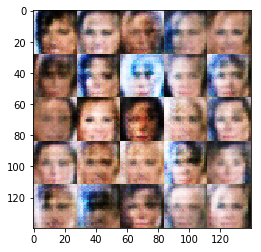

Epoch 1/1... Discriminator Loss: 0.9389... Generator Loss: 1.5332
Epoch 1/1... Discriminator Loss: 1.3577... Generator Loss: 0.9892
Epoch 1/1... Discriminator Loss: 0.9575... Generator Loss: 1.3173
Epoch 1/1... Discriminator Loss: 1.0765... Generator Loss: 1.2798
Epoch 1/1... Discriminator Loss: 1.3135... Generator Loss: 0.5959
Epoch 1/1... Discriminator Loss: 1.2038... Generator Loss: 1.4251
Epoch 1/1... Discriminator Loss: 0.9910... Generator Loss: 1.1833
Epoch 1/1... Discriminator Loss: 1.1796... Generator Loss: 0.7505
Epoch 1/1... Discriminator Loss: 1.2662... Generator Loss: 0.6746
Epoch 1/1... Discriminator Loss: 1.0987... Generator Loss: 0.9890


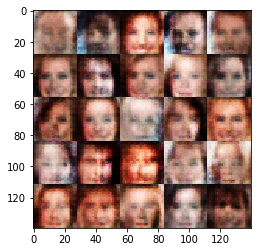

Epoch 1/1... Discriminator Loss: 1.1644... Generator Loss: 0.7457
Epoch 1/1... Discriminator Loss: 1.3128... Generator Loss: 1.8141
Epoch 1/1... Discriminator Loss: 1.4169... Generator Loss: 0.8796
Epoch 1/1... Discriminator Loss: 1.5627... Generator Loss: 0.4099
Epoch 1/1... Discriminator Loss: 0.9616... Generator Loss: 0.9814
Epoch 1/1... Discriminator Loss: 1.0808... Generator Loss: 0.9496
Epoch 1/1... Discriminator Loss: 0.8678... Generator Loss: 1.2215
Epoch 1/1... Discriminator Loss: 0.8636... Generator Loss: 1.3126
Epoch 1/1... Discriminator Loss: 1.3571... Generator Loss: 0.7739
Epoch 1/1... Discriminator Loss: 1.4348... Generator Loss: 0.6833


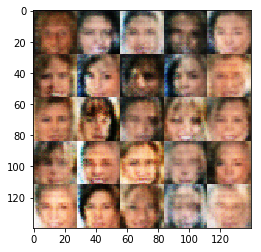

Epoch 1/1... Discriminator Loss: 1.2045... Generator Loss: 0.7798
Epoch 1/1... Discriminator Loss: 1.2423... Generator Loss: 1.0721
Epoch 1/1... Discriminator Loss: 1.2207... Generator Loss: 0.6407
Epoch 1/1... Discriminator Loss: 1.2660... Generator Loss: 0.6878
Epoch 1/1... Discriminator Loss: 1.2685... Generator Loss: 0.9925
Epoch 1/1... Discriminator Loss: 1.2924... Generator Loss: 0.7142
Epoch 1/1... Discriminator Loss: 1.0222... Generator Loss: 1.0503
Epoch 1/1... Discriminator Loss: 1.0080... Generator Loss: 1.1248
Epoch 1/1... Discriminator Loss: 1.0937... Generator Loss: 1.0772
Epoch 1/1... Discriminator Loss: 1.0173... Generator Loss: 1.2105


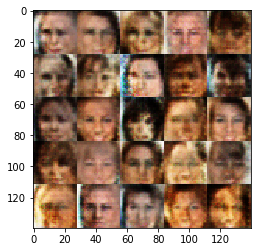

Epoch 1/1... Discriminator Loss: 1.0799... Generator Loss: 0.8508
Epoch 1/1... Discriminator Loss: 1.0268... Generator Loss: 0.9786
Epoch 1/1... Discriminator Loss: 0.9919... Generator Loss: 1.0421
Epoch 1/1... Discriminator Loss: 0.9301... Generator Loss: 1.1604
Epoch 1/1... Discriminator Loss: 1.1878... Generator Loss: 0.7242
Epoch 1/1... Discriminator Loss: 1.1396... Generator Loss: 1.0046
Epoch 1/1... Discriminator Loss: 0.9566... Generator Loss: 1.2053
Epoch 1/1... Discriminator Loss: 1.2680... Generator Loss: 0.5468
Epoch 1/1... Discriminator Loss: 1.0401... Generator Loss: 0.9893
Epoch 1/1... Discriminator Loss: 1.2196... Generator Loss: 0.5353


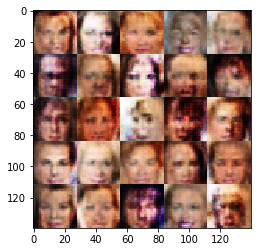

Epoch 1/1... Discriminator Loss: 1.0826... Generator Loss: 1.1293
Epoch 1/1... Discriminator Loss: 1.0446... Generator Loss: 0.8806
Epoch 1/1... Discriminator Loss: 0.9936... Generator Loss: 1.1736
Epoch 1/1... Discriminator Loss: 1.2310... Generator Loss: 0.5931
Epoch 1/1... Discriminator Loss: 1.1800... Generator Loss: 0.7299
Epoch 1/1... Discriminator Loss: 1.0989... Generator Loss: 1.1839
Epoch 1/1... Discriminator Loss: 1.0121... Generator Loss: 1.0432
Epoch 1/1... Discriminator Loss: 1.2893... Generator Loss: 0.9266
Epoch 1/1... Discriminator Loss: 1.2351... Generator Loss: 0.5574
Epoch 1/1... Discriminator Loss: 1.0877... Generator Loss: 0.7574


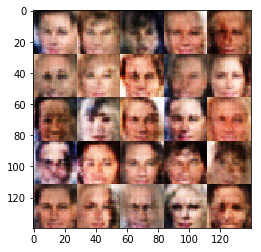

Epoch 1/1... Discriminator Loss: 0.9789... Generator Loss: 1.2328
Epoch 1/1... Discriminator Loss: 0.9966... Generator Loss: 0.9720
Epoch 1/1... Discriminator Loss: 1.1505... Generator Loss: 1.0002
Epoch 1/1... Discriminator Loss: 1.2486... Generator Loss: 1.1284
Epoch 1/1... Discriminator Loss: 0.9770... Generator Loss: 1.0661
Epoch 1/1... Discriminator Loss: 1.1152... Generator Loss: 0.8025
Epoch 1/1... Discriminator Loss: 0.8719... Generator Loss: 1.0653
Epoch 1/1... Discriminator Loss: 1.1952... Generator Loss: 0.5608
Epoch 1/1... Discriminator Loss: 0.9456... Generator Loss: 0.9518
Epoch 1/1... Discriminator Loss: 1.2579... Generator Loss: 0.6641


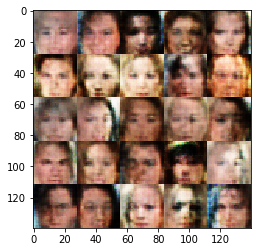

Epoch 1/1... Discriminator Loss: 1.1181... Generator Loss: 1.1905
Epoch 1/1... Discriminator Loss: 1.0874... Generator Loss: 0.9555
Epoch 1/1... Discriminator Loss: 1.3483... Generator Loss: 0.4959
Epoch 1/1... Discriminator Loss: 1.1032... Generator Loss: 0.7660
Epoch 1/1... Discriminator Loss: 1.0075... Generator Loss: 0.9922
Epoch 1/1... Discriminator Loss: 1.1513... Generator Loss: 0.8146
Epoch 1/1... Discriminator Loss: 0.9800... Generator Loss: 1.4017
Epoch 1/1... Discriminator Loss: 0.9954... Generator Loss: 1.0337
Epoch 1/1... Discriminator Loss: 1.1624... Generator Loss: 0.9900
Epoch 1/1... Discriminator Loss: 1.1218... Generator Loss: 0.8872


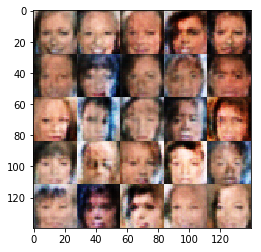

Epoch 1/1... Discriminator Loss: 0.9527... Generator Loss: 0.9048
Epoch 1/1... Discriminator Loss: 1.0744... Generator Loss: 1.0982
Epoch 1/1... Discriminator Loss: 0.9948... Generator Loss: 1.0161
Epoch 1/1... Discriminator Loss: 1.1297... Generator Loss: 1.1362
Epoch 1/1... Discriminator Loss: 0.9606... Generator Loss: 0.9840
Epoch 1/1... Discriminator Loss: 0.9672... Generator Loss: 1.1359
Epoch 1/1... Discriminator Loss: 1.0470... Generator Loss: 0.8989
Epoch 1/1... Discriminator Loss: 1.0548... Generator Loss: 1.1925
Epoch 1/1... Discriminator Loss: 1.1282... Generator Loss: 0.7083
Epoch 1/1... Discriminator Loss: 1.3507... Generator Loss: 0.4913


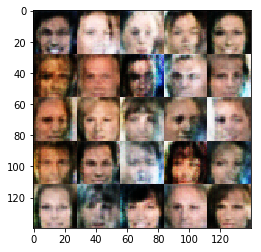

Epoch 1/1... Discriminator Loss: 0.9846... Generator Loss: 1.6983
Epoch 1/1... Discriminator Loss: 1.0051... Generator Loss: 0.7381
Epoch 1/1... Discriminator Loss: 0.9417... Generator Loss: 1.0442
Epoch 1/1... Discriminator Loss: 0.9179... Generator Loss: 1.0640
Epoch 1/1... Discriminator Loss: 1.0813... Generator Loss: 0.6979
Epoch 1/1... Discriminator Loss: 0.9484... Generator Loss: 2.2476
Epoch 1/1... Discriminator Loss: 1.0132... Generator Loss: 0.9595
Epoch 1/1... Discriminator Loss: 1.0376... Generator Loss: 0.9504


In [172]:
batch_size = 128
z_dim = 100
learning_rate = 0.002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.